# Gibson Lanni Model

In [1]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube

import scipy.special

from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S
from fft_conv_pytorch import fft_conv

In [2]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [3]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

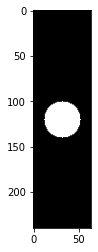

In [4]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [5]:
dirpath = "_beads_roi_extracted_stackreg"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))][:-1]
print(beadslist)
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

['_beads_roi_extracted_stackreg/beads_001_roi000.pt', '_beads_roi_extracted_stackreg/beads_001_roi001.pt', '_beads_roi_extracted_stackreg/beads_001_roi002.pt', '_beads_roi_extracted_stackreg/beads_001_roi003.pt', '_beads_roi_extracted_stackreg/beads_001_roi004.pt', '_beads_roi_extracted_stackreg/beads_002_roi000.pt', '_beads_roi_extracted_stackreg/beads_002_roi001.pt', '_beads_roi_extracted_stackreg/beads_002_roi002.pt']


In [6]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if _ % 100 == 0:
            print(f'epoch {_}, loss {loss:.8f}')
    return loss.item()

In [7]:
class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, params, device, use_fftconv=False):
        super().__init__()
        self.params      = params
        self.device      = device
        self.use_fftconv = use_fftconv
        gibson_lanni     = GibsonLanniModel(params)
        self.psf_rz      = nn.Parameter(torch.tensor(gibson_lanni.PSF_rz, requires_grad=True).float().to(self.device))
        self.psf_rz_s0   = self.psf_rz.shape[0]
        xy               = torch.meshgrid(torch.arange(params["size_y"]),
                                          torch.arange(params["size_x"]),
                                          indexing='ij')
        #self.psf      = nn.Parameter(torch.zeros((self.params["size_z"], self.params["size_x"],  self.params["size_y"]), device=self.device), requires_grad=True)
        r = torch.tensor(gibson_lanni.r)
        x0 = (params["size_x"] - 1) / 2
        y0 = (params["size_y"] - 1) / 2
        r_pixel = torch.sqrt((xy[1] - x0) ** 2 + (xy[0] - y0) ** 2) * params["res_lateral"]
        rs0, = r.shape
        self.rps0, self.rps1 = r_pixel.shape
        r_e = r[:, None, None].expand(rs0, self.rps0, self.rps1)
        r_pixel_e = r_pixel[None].expand(rs0, self.rps0, self.rps1)
        r_index = torch.argmin(torch.abs(r_e- r_pixel_e), dim=0)
        r_index_fe = r_index.flatten().expand(self.psf_rz_s0, -1)
        self.r_index_fe = r_index_fe.to(self.device)
        self.z_pad   = int((params["size_z"] - self.params["res_axial"] // self.params["res_lateral"] + 1) // 2)
        self.x_pad   = (params["size_x"]) // 2
        self.y_pad   = (params["size_y"]) // 2
        self.stride  = (int(self.params["res_axial"] // self.params["res_lateral"]) + 1, 1, 1)
        self.index   = torch.tensor([0], device=self.device)#.reshape(self.params["size_x"], self.params["size_y"])

    def forward(self, x):
        psf = torch.gather(self.psf_rz, 1, self.r_index_fe)
        psf = psf / torch.sum(psf)
        psf = psf.reshape(self.psf_rz_s0, self.rps0, self.rps1)
        if self.use_fftconv:
            _x   = fft_conv(signal  = x                                    ,
                            kernel  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        else:
            _x   = F.conv3d(input   = x                                    ,
                            weight  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        return _x


class GibsonLanniModel():
    def __init__(self, params):
        size_x = params["size_x"]#256 # # # # param # # # #
        size_y = params["size_y"]#256 # # # # param # # # #
        size_z = params["size_z"]#128 # # # # param # # # #

        # Precision control
        num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
        num_samples  = 1000 # Number of pupil samples along radial direction
        oversampling = 1    # Defines the upsampling ratio on the image space grid for computations

        # Microscope parameters
        NA          = params["NA"]#1.1   # # # # param # # # #
        wavelength  = params["wavelength"]#0.910 # microns # # # # param # # # #
        M           = params["M"]#25    # magnification # # # # param # # # #
        ns          = 1.33  # specimen refractive index (RI)
        ng0         = 1.5   # coverslip RI design value
        ng          = 1.5   # coverslip RI experimental value
        ni0         = 1.5   # immersion medium RI design value
        ni          = 1.5   # immersion medium RI experimental value
        ti0         = 150   # microns, working distance (immersion medium thickness) design value
        tg0         = 170   # microns, coverslip thickness design value
        tg          = 170   # microns, coverslip thickness experimental value
        res_lateral = params["res_lateral"]#0.05  # microns # # # # param # # # #
        res_axial   = params["res_axial"]#0.5   # microns # # # # param # # # #
        pZ          = 2     # microns, particle distance from coverslip

        # Scaling factors for the Fourier-Bessel series expansion
        min_wavelength = 0.436 # microns
        scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength
        x0 = (size_x - 1) / 2
        y0 = (size_y - 1) / 2
        max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0)))
        r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling
        self.r = r
        a = min([NA, ns, ni, ni0, ng, ng0]) / NA
        rho = np.linspace(0, a, num_samples)

        z = res_axial * np.arange(-size_z / 2, size_z /2) + res_axial / 2

        OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
        OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
        OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
        W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)
        phase = np.cos(W) + 1j * np.sin(W)
        J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)
        C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)
        b = 2 * np.pi * r.reshape(-1, 1) * NA / wavelength
        J0 = lambda x: scipy.special.j0(x)
        J1 = lambda x: scipy.special.j1(x)
        denom = scaling_factor * scaling_factor - b * b
        R = scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a
        R /= denom
        PSF_rz = (np.abs(R.dot(C))**2).T
        self.PSF_rz = PSF_rz / np.max(PSF_rz)

    def __call__(self):
        return self.PSF_rz


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x



class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train", dist="double_exp",
                 apply_hill=False, use_fftconv=False):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z       = params["mu_z"]
            self.sig_z      = params["sig_z"]
            self.log_ez0    = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
        else:
            raise(NotImplementedError())
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(params      = params         ,
                               device      = device         ,
                               use_fftconv = use_fftconv    ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)


    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x


/tmp/ipykernel_584403/1039688268.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)


stackreg/beads_001_roi000
epoch 0, loss 0.00517037
epoch 100, loss 0.00158341
epoch 200, loss 0.00155319
epoch 300, loss 0.00148750
epoch 400, loss 0.00147259
epoch 500, loss 0.00143209
epoch 600, loss 0.00137325
epoch 700, loss 0.00135885
epoch 800, loss 0.00133569
epoch 900, loss 0.00132866
stackreg/beads_001_roi001
epoch 0, loss 0.01139129
epoch 100, loss 0.00767375
epoch 200, loss 0.00761978
epoch 300, loss 0.00756280
epoch 400, loss 0.00752235
epoch 500, loss 0.00751212
epoch 600, loss 0.00750108
epoch 700, loss 0.00748082
epoch 800, loss 0.00749623
epoch 900, loss 0.00746135
stackreg/beads_001_roi002
epoch 0, loss 0.00497095
epoch 100, loss 0.00129287
epoch 200, loss 0.00126675
epoch 300, loss 0.00121133
epoch 400, loss 0.00119803
epoch 500, loss 0.00118671
epoch 600, loss 0.00116695
epoch 700, loss 0.00115591
epoch 800, loss 0.00109742
epoch 900, loss 0.00108519
stackreg/beads_001_roi003
epoch 0, loss 0.01070831
epoch 100, loss 0.00601579
epoch 200, loss 0.00594584
epoch 300, lo

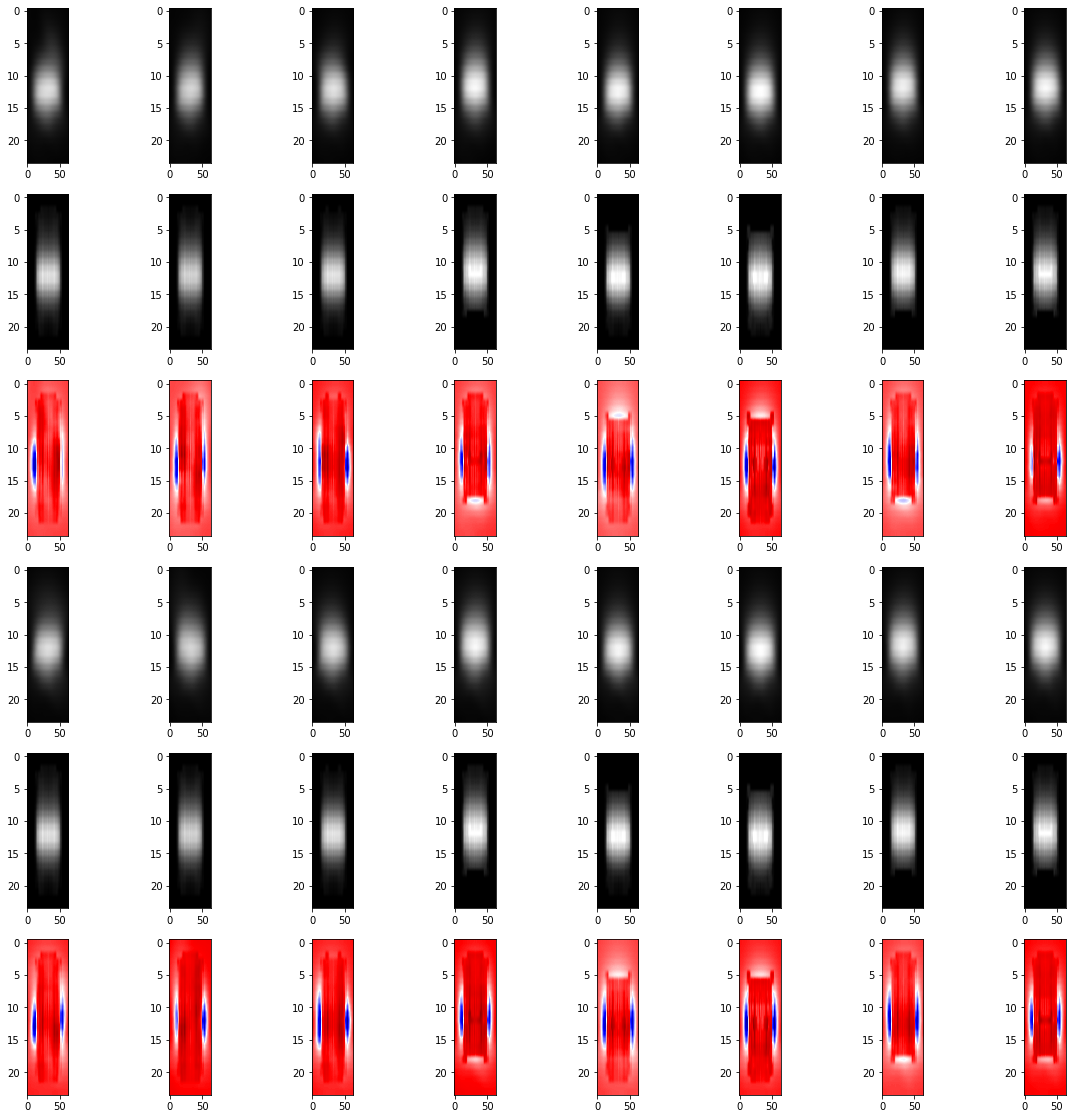

[0.0013260121922940016, 0.007455936633050442, 0.001082784030586481, 0.005735411308705807, 0.001303569762967527, 0.0015033092349767685, 0.0011249072849750519, 0.0013601342216134071]
stackreg/beads_001_roi000
epoch 0, loss 0.00465291
epoch 100, loss 0.00126553
epoch 200, loss 0.00081018
epoch 300, loss 0.00074711
epoch 400, loss 0.00071752
epoch 500, loss 0.00072635
epoch 600, loss 0.00066002
epoch 700, loss 0.00062966
epoch 800, loss 0.00061968
epoch 900, loss 0.00061643
stackreg/beads_001_roi001
epoch 0, loss 0.01087406
epoch 100, loss 0.00739947
epoch 200, loss 0.00713584
epoch 300, loss 0.00707365
epoch 400, loss 0.00698751
epoch 500, loss 0.00697808
epoch 600, loss 0.00695017
epoch 700, loss 0.00691590
epoch 800, loss 0.00690588
epoch 900, loss 0.00689832
stackreg/beads_001_roi002
epoch 0, loss 0.00445443
epoch 100, loss 0.00100429
epoch 200, loss 0.00061320
epoch 300, loss 0.00053402
epoch 400, loss 0.00049402
epoch 500, loss 0.00049959
epoch 600, loss 0.00044260
epoch 700, loss 0.

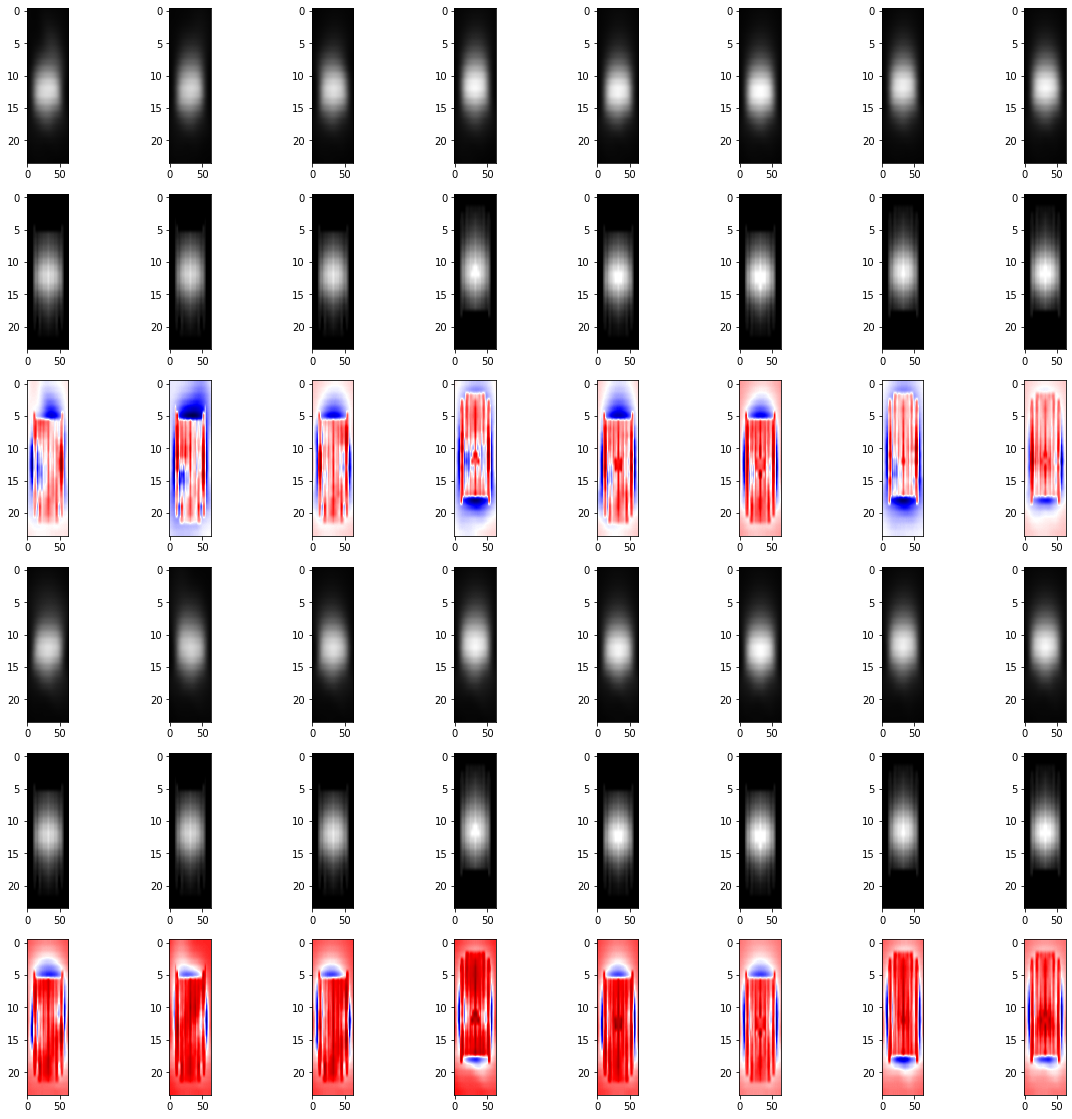

[0.000615743629168719, 0.006896661128848791, 0.0004109832807444036, 0.0049024843610823154, 0.00046357110841199756, 0.0005183169851079583, 0.0004027484683319926, 0.0004908889532089233]
stackreg/beads_001_roi000
epoch 0, loss 0.00361236
epoch 100, loss 0.00069713
epoch 200, loss 0.00067110
epoch 300, loss 0.00065236
epoch 400, loss 0.00055282
epoch 500, loss 0.00046888
epoch 600, loss 0.00041318
epoch 700, loss 0.00037908
epoch 800, loss 0.00036894
epoch 900, loss 0.00036509
stackreg/beads_001_roi001
epoch 0, loss 0.00977506
epoch 100, loss 0.00702090
epoch 200, loss 0.00699515
epoch 300, loss 0.00692644
epoch 400, loss 0.00686766
epoch 500, loss 0.00683319
epoch 600, loss 0.00671968
epoch 700, loss 0.00671310
epoch 800, loss 0.00671204
epoch 900, loss 0.00670641
stackreg/beads_001_roi002
epoch 0, loss 0.00342018
epoch 100, loss 0.00048976
epoch 200, loss 0.00046588
epoch 300, loss 0.00044627
epoch 400, loss 0.00035090
epoch 500, loss 0.00029253
epoch 600, loss 0.00030909
epoch 700, loss

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
kernels = [3, 9, 31, 61]
lossnames = ["gker3", "gker9", "gker31", "gker61"]
dc = {}
z = 161
for ker, lossname in zip(kernels, lossnames):
    x = ker
    y = ker
    params = {"mu_z"       : 0.1    ,
              "sig_z"      : 0.1    ,
              "size_x"     : x    ,
              "size_y"     : y     ,
              "size_z"     : 161  ,
              "NA"         : 1.33   ,
              "wavelength" : 0.910  ,
              "M"          : 25     ,
              "res_lateral": 0.05   ,
              "res_axial"  : 0.5    ,
              "sig_eps"    : 0.01   ,
              "scale"      : 6
              }
    beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
    beadslist.pop(-1)
    #torch.autograd.set_detect_anomaly(True)
    losses = []
    fig, ax = plt.subplots(nrows = 6, ncols=len(beadslist), figsize=(20, 20))
    for i, bead in enumerate(beadslist):
        dirpath = "_beads_roi_extracted_stackreg"
        label = torch.load(bead, map_location="cuda").to(torch.float32)
        blur = ImagingProcess(device       = device           ,
                              params       = params           ,
                              z            = z                ,
                              x            = x                ,
                              y            = y                ,
                              mode         = "train"          ,
                              dist         = "gaussian"       ,
                              apply_hill   = False            ,
                              use_fftconv  = True             ,
                              )
        optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
        print(bead[21:-3])
        loss = train_loop(obj, blur, label, optimizer, 1000)
        label = label.detach().to("cpu")
        x_label = label[0, :, 64, 32:96]
        y_label = label[0, :, 32:96, 64]
        t = data.to(device).unsqueeze(0)
        t = blur(t).squeeze(0)
        t = t.detach().to('cpu')
        x_img = t[0, :, 64, 32:96]
        y_img = t[0, :, 32:96, 64]
        ax[0, i].imshow(x_label, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[1, i].imshow(x_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[2, i].imshow((x_img - x_label + 1) / 2, aspect=10, cmap='seismic')
        ax[3, i].imshow(y_label, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[4, i].imshow(y_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[5, i].imshow((y_img - y_label + 1) / 2, aspect=10, cmap='seismic')
        losses.append(loss)
    plt.show()
    print(losses)
    dc[f"{lossname}"] = losses

In [ ]:
dc

In [ ]:
fit12_6 = {'ker3': [0.0016062450595200062,
  0.0076214224100112915,
  0.0012962775072082877,
  0.0059004477225244045,
  0.0016468893736600876,
  0.0019721209537237883,
  0.0012480757432058454,
  0.0015201501082628965],
 'ker9': [0.001343564479611814,
  0.007392687723040581,
  0.00104308663867414,
  0.005579154938459396,
  0.0013445464428514242,
  0.001620264258235693,
  0.0009684868855401874,
  0.0012002362636849284],
 'ker31': [0.0006834962405264378,
  0.006881402805447578,
  0.00047583499690517783,
  0.004972068592905998,
  0.0007150477031245828,
  0.0008839474758133292,
  0.0004427439416758716,
  0.0004963860264979303],
 'ker61': [0.0006305397255346179,
  0.006845209281891584,
  0.00043824277236126363,
  0.0049494849517941475,
  0.0006850848440080881,
  0.0008546472527086735,
  0.00041969932499341667,
  0.00046377157559618354]}

In [ ]:
physics = [dc[i] for i in dc]
labels = ["p-3", "p-9", "p-31", "p-61"]
fig, ax = plt.subplots(figsize=(10, 7))
plt.title("physics kernel_size")
plt.xticks(rotation=45)
vp = ax.boxplot(physics, labels=labels, showfliers=True)
plt.show()

In [ ]:
x = [3, 9, 31, 61]
y = [sum(m)/len(m) for m in physics]
plt.scatter(x, y)
plt.show()

In [ ]:
fitting = [fit12_6[i] for i in fit12_6]
physics = [dc[i] for i in dc]
fitandphy = [*fitting, *physics]
labels = ["f-3", "f-9", "f-31", "f-61", "p-3", "p-9", "p-31", "p-61"]
fig, ax = plt.subplots(figsize=(10, 7))
plt.title("gaussian fit vs physics")
plt.xticks(rotation=45)
vp = ax.boxplot(fitandphy, labels=labels, showfliers=True)
plt.show()

In [ ]:
x = [3, 9, 31, 61]
y = [sum(m)/len(m) for m in fitting]
plt.scatter(x, y)
plt.show()

In [ ]:
x = [i for i in range(1, 9)]
y = [sum(m)/len(m) for m in fitandphy]
plt.scatter(x, y)
plt.show()